In [1]:
!pip install -U transformers

     |████████████████████████████████| 3.4 MB 6.6 MB/s 
     |████████████████████████████████| 596 kB 20.3 MB/s 
     |████████████████████████████████| 895 kB 24.8 MB/s 
     |████████████████████████████████| 61 kB 496 kB/s 
     |████████████████████████████████| 3.3 MB 41.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/msmarco-roberta-base-v3')
model = AutoModel.from_pretrained('sentence-transformers/msmarco-roberta-base-v3')

# Tokenize sentences

Downloading:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/678 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
sentences = ["see I have a rhyme repeating", "the rain in @spain"]

In [3]:
import torch

In [ ]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
sentence_embeddings.shape

torch.Size([2, 768])

In [ ]:
def get_tweets_embeddings(tweets):
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
  with torch.no_grad():
    model_output = model(**encoded_input)
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  return sentence_embeddings

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [8]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path 
dir = Path("/content/drive/Shareddrives/CIS530")
data_dir = dir / "data"
train = pd.read_parquet(data_dir / "train.pq")
test = pd.read_parquet(data_dir / "test.pq")

In [9]:
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
home_embeddings = train.home_tweets.progress_apply(get_tweets_embeddings)

  0%|          | 0/3228 [00:00<?, ?it/s]

In [ ]:
away_embeddings = train.away_tweets.progress_apply(get_tweets_embeddings)

  0%|          | 0/3228 [00:00<?, ?it/s]

In [ ]:
all_home = torch.cat(home_embeddings.apply(lambda x: x.reshape(1, -1, 768)).to_list())

In [ ]:
import numpy as np
np.save(data_dir / "train_home_embeddings.npy", all_home.numpy())

In [ ]:
all_away = torch.cat(away_embeddings.apply(lambda x: x.reshape(1, -1, 768)).to_list())

In [ ]:
np.save(data_dir / "train_away_embeddings.npy", all_away.numpy())

In [ ]:
test_home = test.home_tweets.progress_apply(get_tweets_embeddings)
all_test_home = torch.cat(test_home.apply(lambda x: x.reshape(1, -1, 768)).to_list())
np.save(data_dir / "test_home_embeddings.npy", all_test_home.numpy())


  0%|          | 0/807 [00:00<?, ?it/s]

In [ ]:
test_away = test.away_tweets.progress_apply(get_tweets_embeddings)
all_test_away = torch.cat(test_away.apply(lambda x: x.reshape(1, -1, 768)).to_list())
np.save(data_dir / "test_away_embeddings.npy", all_test_away.numpy())


  0%|          | 0/807 [00:00<?, ?it/s]

In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
class embeddedDataset(Dataset):
  def __init__(self, home_embeddings,away_embeddings, labels):
    self.home_embeddings = home_embeddings 
    self.away_embeddings = away_embeddings
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {
        "home": self.home_embeddings[idx].flatten(), 
        "away": self.away_embeddings[idx].flatten(),
        "label": torch.tensor([1.0, 0]) if self.labels[idx] == 0 else torch.tensor([0, 1.0])
    }
    return item
  def __len__(self):
    return len(self.home_embeddings)

In [18]:
class embeddedDataset(Dataset):
  def __init__(self, home_embeddings,away_embeddings, labels):
    self.home_embeddings = torch.from_numpy(home_embeddings)
    self.away_embeddings = torch.from_numpy(away_embeddings)
    self.labels = labels
  
  def __getitem__(self, idx):
    item = {
        "home": self.home_embeddings[idx, :, :].flatten(), 
        "away": self.away_embeddings[idx, :, :].flatten(),
        "label": torch.tensor([1.0, 0]) if self.labels[idx] == 0 else torch.tensor([0, 1.0])
    }
    return item
  def __len__(self):
    return len(self.home_embeddings)

In [20]:
train_ds = embeddedDataset(train_home_embeddings, train_away_embeddings, train["HOME_TEAM_WINS"].tolist())
train_dl = DataLoader(train_ds, batch_size=8)

In [21]:
valid_ds = embeddedDataset(test_home_embeddings, test_away_embeddings, test["HOME_TEAM_WINS"].tolist())
valid_dl = DataLoader(valid_ds, batch_size=8)

In [23]:
test_dl = DataLoader(valid_ds, batch_size=1)

In [25]:
from torch import nn as nn

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
def libndrop(in_features, out_features, dropout):
  return nn.Sequential(nn.Linear(in_features=in_features, out_features=out_features), 
                       nn.BatchNorm1d(out_features), 
                       nn.ReLU(), 
                       nn.Dropout(dropout))
class HedgeModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = libndrop(3072, 768, 0.5)
    self.lin2 = libndrop(768, 384, 0.5)
    self.lin3 = libndrop(384, 384 // 2, 0.5)
    self.output = nn.Linear(in_features=384//2 , out_features=2)
  def forward(self, batch):
    home_embeddings = batch["home"]
    away_embeddings = batch["away"]
    output = torch.cat((home_embeddings, away_embeddings), dim=-1)
    output = self.lin1(output)
    output = self.lin2(output)
    output = self.lin3(output)
    output = self.output(output)
    target = batch["label"]
    return output, target


In [28]:
model = HedgeModel()
model.to(device)

HedgeModel(
  (lin1): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin2): Sequential(
    (0): Linear(in_features=768, out_features=384, bias=True)
    (1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin3): Sequential(
    (0): Linear(in_features=384, out_features=192, bias=True)
    (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=192, out_features=2, bias=True)
)

In [ ]:
for param in model.parameters():
  param.requires_grad=True

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from tqdm.auto import tqdm

In [ ]:
NUM_EPOCHS = 20
NUM_TRAINING_STEPS = NUM_EPOCHS * len(train_dl)
CHECKPOINT_AFTER_STEPS = 100

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = LinearLR(optimizer, start_factor=0.5, total_iters=NUM_TRAINING_STEPS)


In [29]:
temp_dir = data_dir / "temp"
temp_dir.mkdir(exist_ok=True)

In [ ]:
training_losses = []
validation_losses = []

In [ ]:
def get_loss(dataloader, model, criterion):
  model.eval()
  validation_loss = 0
  num_of_batches = len(dataloader)

  for batch in tqdm(dataloader, total = len(dataloader)):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(batch)
      loss = criterion(*outputs)
      validation_loss += loss.cpu().detach().item() / num_of_batches
  return validation_loss


best_validation_loss = np.Inf
progress_bar = tqdm(range(NUM_TRAINING_STEPS))
criterion = nn.BCEWithLogitsLoss()
step_counter = 0
current_training_loss = 0
for epoch in range(NUM_EPOCHS):
  for ind, batch in enumerate(train_dl):
    model.train()
    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(batch)
    loss = criterion(*outputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    current_training_loss += loss.item()
    progress_bar.update(1)
    step_counter += 1
    if ind % CHECKPOINT_AFTER_STEPS == 0:
      training_losses.append(current_training_loss/step_counter)
      validation_loss = get_loss(valid_dl, model, criterion)
      validation_losses.append(validation_loss)
      print(f"Train: {current_training_loss/(step_counter+1)}, validation: {validation_loss}")
      current_training_loss = 0
      step_counter = 0
      if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        print(f"MODEL IMPROVED, {validation_loss}")
        torch.save(model.state_dict(), str(temp_dir/"model_allfeats_best_state_dict2"))
        num_iter = len(training_losses)
        # plt.plot(range(num_iter), training_losses, label="train")
        # plt.plot(range(num_iter), validation_losses, label="valid")
        # plt.legend()
        # plt.show()




  0%|          | 0/8080 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.35550639033317566, validation: 0.6932673454284671
MODEL IMPROVED, 0.6932673454284671


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7095676920201519, validation: 644.972871232741


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7064260338792706, validation: 3204.2645529567603


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6930702901122594, validation: 2600.1376681186184


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.704062828333071, validation: 1632.8196812997946


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5472733020782471, validation: 1671.0243907966228


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7048819189024443, validation: 1734.1813233630496


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7059414457566667, validation: 1922.1369906888144


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.702724023030536, validation: 1880.4525623888064


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7034154315986255, validation: 1810.6971163608061


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5601782917976379, validation: 1581.0840070365678


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7098686624281477, validation: 1142.7975681418238


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.69251548535753, validation: 1138.7982760892057


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7049739862432575, validation: 1247.4863544124187


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6923474397989783, validation: 1243.1697028131755


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5845696449279785, validation: 1677.3723558482561


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7147680786576601, validation: 312.5043380284074


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7090502835736416, validation: 716.8453894889


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7027586840166904, validation: 473.0350965745379


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6966835720704334, validation: 523.9540751240039


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5671884417533875, validation: 697.0489684756442


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7116959095001221, validation: 436.8267426443573


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7010465205305874, validation: 504.2079363530222


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6973193500301625, validation: 1563.783082263304


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.688980917824377, validation: 833.832880756642


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5694412469863892, validation: 697.7038074153484


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.707631253960109, validation: 816.4034958641126


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6920616343469903, validation: 2210.642362991182


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6966577113264858, validation: 262.2691942724851


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6996847515058989, validation: 924.1697717043435


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.4896050333976746, validation: 965.1924710415374


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7051271719507651, validation: 796.7703358867378


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.693368385333826, validation: 694.2404694509979


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6981988136130984, validation: 999.5446889140816


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6937411173735515, validation: 1605.8925823551592


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5666882514953613, validation: 1259.4363025627508


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6938768035114402, validation: 1494.507377095742


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6829572284575736, validation: 1352.3572523664723


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6939502629903284, validation: 1177.7160260795363


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6838712479808543, validation: 971.5425934744353


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.4859375834465027, validation: 920.0195481706379


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6895488618624093, validation: 633.098458620581


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6928253941016622, validation: 1285.8413557298106


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7078019563514407, validation: 621.8017422515567


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6797753725901688, validation: 426.2090041661025


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5501563072204589, validation: 623.6776103406844


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6894422031865262, validation: 445.6326411785465


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6847369033511322, validation: 1685.5194415101914


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6982872267760852, validation: 1216.6088809778194


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6840565352156611, validation: 676.210532009012


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5296560883522033, validation: 803.6075613191811


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7006582423011856, validation: 1042.65252836624


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6892146668811836, validation: 2286.6712344330135


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6953327042041438, validation: 1876.711384688275


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6903736113321663, validation: 1257.909595451733


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5391188859939575, validation: 977.6743701897045


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7032087586893894, validation: 1435.0415172010357


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6942899947119231, validation: 504.9194969328324


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6921815382372035, validation: 841.039065068312


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6935487188915215, validation: 962.3660130264727


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5520362973213195, validation: 1148.44542943369


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7018909035342755, validation: 859.4643216274749


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6840936187470313, validation: 1115.922527048847


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.683676269384894, validation: 911.6516016591896


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6798563056653089, validation: 487.13212494802957


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5176977992057801, validation: 324.32157270979167


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.699251140108203, validation: 2161.5977916150982


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.687358290842264, validation: 1255.4265771242656


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6903555983363991, validation: 512.139931556022


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6816898543055695, validation: 593.9173028020575


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5112337112426758, validation: 615.5443393216274


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7023870608594158, validation: 1209.0255921618777


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6732833473989279, validation: 1206.1671091211908


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.686679599603804, validation: 584.5991655104234


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6873191848839864, validation: 751.0419090950846


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5369365453720093, validation: 704.999538308323


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7046280898670159, validation: 696.6169921572849


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6914172497126135, validation: 499.0732349357982


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6799632482009359, validation: 583.1839626803255


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6790167624407476, validation: 429.5167175897274


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5145529866218567, validation: 272.2386428530853


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6906274250238249, validation: 675.4219602074955


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6946290448160455, validation: 409.1426183115137


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6876452246514877, validation: 483.7487140315593


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6888401720783498, validation: 1463.3162155906748


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5168496608734131, validation: 1091.3991116061068


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.7065025774559172, validation: 624.7933113929072


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6806955856852012, validation: 1082.5350187698207


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6910179340013183, validation: 414.37774280510314


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6892253968975331, validation: 954.8001579058052


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5151741862297058, validation: 1004.2238165222778


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6938385514929744, validation: 429.9883956153797


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6874504508358417, validation: 290.29650886460104


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6888912320137024, validation: 871.8257582258467


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6835860297231391, validation: 278.06742904209847


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.5483450055122375, validation: 242.63281325538577


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6929832272010275, validation: 1111.7734474710903


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6770095152430015, validation: 787.0952364477783


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6874195172054933, validation: 762.3798732946409


  0%|          | 0/101 [00:00<?, ?it/s]

Train: 0.6932408697534316, validation: 572.7038306812251


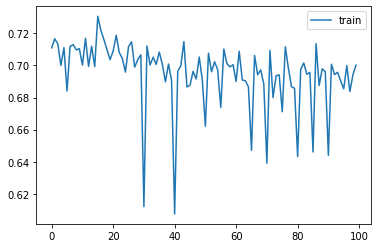

In [ ]:
import matplotlib.pyplot as plt
num_evals = len(training_losses)
plt.plot(range(num_evals), training_losses, label="train")
plt.legend()
plt.show()

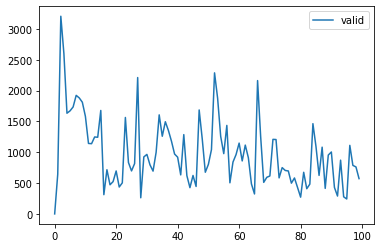

In [ ]:
import matplotlib.pyplot as plt
num_evals = len(training_losses)
plt.plot(range(num_evals), validation_losses, label="valid")
plt.legend()
plt.show()

# Ablation Study for Model


In [30]:
model.load_state_dict(torch.load(str(temp_dir/"model_allfeats_best_state_dict2")))
train_home_embeddings = np.load(data_dir / "train_home_embeddings.npy")
train_away_embeddings = np.load(data_dir/ "train_away_embeddings.npy")
test_away_embeddings = np.load(data_dir / "test_away_embeddings.npy")
test_home_embeddings = np.load(data_dir / "test_home_embeddings.npy")

<All keys matched successfully>

In [ ]:
criterion

BCEWithLogitsLoss()

In [55]:
outputs = []
targets = []
losses = []
model.eval()
for batch in tqdm(test_dl):
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    pred, target = model(batch)
    outputs.append(pred)
    targets.append(target)
    losses.append(criterion(pred, target).reshape(-1, 1))

  0%|          | 0/807 [00:00<?, ?it/s]

In [56]:
outputs = torch.cat(outputs)
targets = torch.cat(targets)
losses = torch.cat(losses).squeeze()

In [57]:
outputs.shape, targets.shape
preds = outputs.argmax(dim=1)
tget = targets.argmax(dim=1)

In [58]:
from sklearn.metrics import accuracy_score, f1_score

In [59]:
accuracy_score(tget, preds), f1_score(tget, preds)

(0.5811648079306072, 0.7351097178683387)

In [ ]:
losses.shape

torch.Size([807])

In [ ]:
for out in outputs:
  print(out)

tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2392.3008,   836.9996])
tensor([-2

In [38]:
def get_loss(dataloader, model, criterion):
  model.eval()
  validation_loss = 0
  num_of_batches = len(dataloader)

  for batch in tqdm(dataloader, total = len(dataloader)):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(batch)
      loss = criterion(*outputs)
      validation_loss += loss.cpu().detach().item() / num_of_batches
  return validation_loss

In [39]:
base_loss = get_loss(train_dl, model, criterion)

  0%|          | 0/404 [00:00<?, ?it/s]

In [40]:
criterion = nn.BCEWithLogitsLoss()

In [41]:
base_loss

0.6932667390544822

In [42]:
train_ds

In [44]:
foo = np.arange(8).reshape(4,2, 1)

In [45]:
foo

array([[[0],
        [1]],

       [[2],
        [3]],

       [[4],
        [5]],

       [[6],
        [7]]])

In [46]:
np.random.shuffle(foo)

In [47]:
foo

array([[[2],
        [3]],

       [[6],
        [7]],

       [[0],
        [1]],

       [[4],
        [5]]])

In [49]:
train_home_copy = np.copy(train_home_embeddings)

In [50]:
np.random.shuffle(train_home_copy)

In [51]:
train_ds = embeddedDataset(train_home_copy, train_away_embeddings, train["HOME_TEAM_WINS"].tolist())
s_train_dl = DataLoader(train_ds, batch_size=8)
get_loss(s_train_dl, model, criterion)

  0%|          | 0/404 [00:00<?, ?it/s]

0.6932667390544822

In [52]:
train_away_copy = np.copy(train_away_embeddings)
np.random.shuffle(train_away_copy)
train_ds = embeddedDataset(train_home_embeddings, train_away_copy, train["HOME_TEAM_WINS"].tolist())
s_train_dl = DataLoader(train_ds, batch_size=8)
get_loss(s_train_dl, model, criterion)

  0%|          | 0/404 [00:00<?, ?it/s]

0.6932667390544822

In [53]:
labels = train["HOME_TEAM_WINS"].values
np.random.shuffle(labels)
train_ds = embeddedDataset(train_home_embeddings, train_away_embeddings, labels.tolist())
s_train_dl = DataLoader(train_ds, batch_size=8)
get_loss(s_train_dl, model, criterion)

  0%|          | 0/404 [00:00<?, ?it/s]

0.6932667390544823

In [54]:
train_ds = embeddedDataset(train_away_embeddings, train_home_embeddings, train["HOME_TEAM_WINS"].tolist())
s_train_dl = DataLoader(train_ds, batch_size=8)
get_loss(s_train_dl, model, criterion)

  0%|          | 0/404 [00:00<?, ?it/s]

0.6932667390544823

In [60]:
train

,GAME_ID,HOME_TEAM_ID,TEAM_ID_away,HOME_TEAM_WINS,tweets,HOME_NICK,AWAY_NICK,home_tweets,away_tweets
2328,20800962,1610612745,1610612747,1,"[@OfficialRockets I saw that, messed up my pre...",Rockets,Lakers,"[@OfficialRockets I saw that, messed up my pre...",[@LakersDotCom good!! he shouldn't have even ...
3249,21600631,1610612740,1610612753,0,"[@PelicansNBA sure whatever, @PelicansNBA we n...",Pelicans,Magic,"[@PelicansNBA sure whatever, @PelicansNBA we n...",[@OrlandoMagic Did Evan Fournier play in yeste...
1840,21000198,1610612745,1610612756,0,[@PhoenixSuns Follow me back pls? I'm Brazilia...,Rockets,Suns,[@HoustonRockets Courtney Lee & @Spurs George ...,[@PhoenixSuns Follow me back pls? I'm Brazilia...
1915,11000037,1610612738,1610612761,1,[@raptors will tomorrow nights game be broadca...,Celtics,Raptors,[@celtics the celtics will go to NBA 10-11 cha...,[@raptors will tomorrow nights game be broadca...
1008,21201156,1610612752,1610612764,1,"[@nyknicks Follow Back, “@nyknicks: Five Take...",Knicks,Wizards,"[@nyknicks Follow Back, “@nyknicks: Five Take...","[@WashWizards @nrdc burn more coal 😁👍😎, @WashW..."
...,...,...,...,...,...,...,...,...,...
811,21300577,1610612746,1610612742,1,[@dallasmavs New Jersey adding to the collecti...,Clippers,Mavericks,"[@LAClippers way to go Clippers., @LAClippers ...",[@dallasmavs New Jersey adding to the collecti...
3654,21500216,1610612753,1610612752,1,[@OrlandoMagic @oahastings agrees! https://...,Magic,Knicks,[@OrlandoMagic @oahastings agrees! https://...,[@nyknicks @instagram Ok........Afflalo him on...
2520,21800956,1610612762,1610612740,0,[@utahjazz fans have seen him in the zone a fe...,Jazz,Pelicans,[@utahjazz fans have seen him in the zone a fe...,"[@PelicansNBA take whoever you want, @Pelicans..."
558,21900566,1610612760,1610612745,1,[@okcthunder I've been singing this song ever ...,Thunder,Rockets,[@okcthunder I've been singing this song ever ...,"[@HoustonRockets @TISSOT My man looks tired, @..."


In [61]:
train["num_home"] = train["home_tweets"].apply(len)
train["num_away"] = train["away_tweets"].apply(len)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


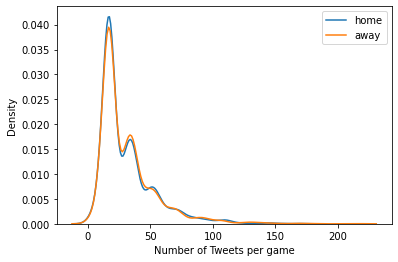

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(train["num_home"], hist=False, rug=False, label="home")
sns.distplot(train["num_away"], hist=False, rug=False, label="away")
plt.xlabel("Number of Tweets per game")
plt.legend()
plt.show()